In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import pad_sequences
from itertools import chain
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
market_train = pd.read_csv('market_since09_v1.csv')

In [4]:
print(market_train.shape)
market_train.head()

(3340144, 16)


,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2009-01-02,A.N,Agilent Technologies Inc,3030118.0,16.24,15.60,0.039028,0.045576,0.029112,0.042122,-0.005511,-0.037037,-0.026992,-0.033293,0.179633,1.0
1,2009-01-02,AAI.N,AirTran Holdings Inc,1551494.0,4.51,4.36,0.015766,-0.035398,-0.018756,-0.047927,0.127500,0.141361,0.110937,0.144485,0.048476,0.0
2,2009-01-02,AAP.N,Advance Auto Parts Inc,795900.0,34.14,33.86,0.014562,0.022652,-0.010692,0.009156,0.035283,0.047398,-0.005260,0.054363,0.029782,1.0
3,2009-01-02,AAPL.O,Apple Inc,26964210.0,90.75,85.58,0.063269,-0.004884,0.033274,-0.015174,0.017833,-0.059560,-0.029117,-0.051910,-0.026166,1.0
4,2009-01-02,AB.N,AllianceBernstein Holding LP,661549.0,21.25,20.98,0.022126,0.095561,-0.054235,0.055434,0.074317,0.085360,-0.042303,0.107932,0.046983,1.0


import datetime
market_train['time'] = market_train['time'].dt.date
market_train = market_train[market_train['time']>=datetime.date(2009, 1, 1)]

In [2]:
def one_hot_encoder(df, cat_cols):
    cat_dummies = pd.get_dummies(df[cat_cols].astype(str))
    df.drop(columns=cat_cols, inplace=True) 
    df = pd.concat([df, cat_dummies], axis=1)
    new_cat_cols = list(cat_dummies.columns)
    del cat_dummies
    return df, new_cat_cols

def prep_market(market_df, train=True):
    # exclude outliers
    # 3-sigma rule: in normal distribution, 99% of datapoints are within 3 std away from mean
    num_cols = [col for col in market_df.columns if col not in ['time', 'assetCode', 'assetName', 'universe']]
    for col in num_cols:
        market_df = market_df[np.abs(market_df[col]-market_df[col].mean()) <= 3*market_df[col].std()]
    
    # one-hot encoding
    market_df['assetCode_cat'] = market_df['assetCode'].map(lambda x: x.split('.')[1]).astype(str)
    market_df, new_cat_cols = one_hot_encoder(market_df, ['assetCode_cat'])
    
    if train:
        try:
            market_df.returnsOpenNextMktres10 = market_df.returnsOpenNextMktres10.clip(-1, 1)
            market_df['label'] = market_df.returnsOpenNextMktres10.map(lambda x: 0 if x < 0 else 1)
        except:
            pass
    
    print(market_df.shape)
    return market_df, new_cat_cols

In [5]:
market_train, new_cat_cols = prep_market(market_train)

(2811258, 24)


In [6]:
num_cols = [col for col in market_train.columns if col not in ['time','assetCode', 'assetName', 'universe', 'label', 
                                                               'assetCode_cat_A', 'assetCode_cat_N', 'assetCode_cat_O',
                                                               'assetCode_cat_OB', 'assetCode_cat_OQ', 'assetCode_cat_P', 
                                                               'assetCode_cat_UNKNOWN', 'returnsOpenNextMktres10']]

market_train[num_cols] = market_train[num_cols].fillna(0)

In [7]:
def split(*arg, test_size=0.2):
    sets = []
    for i in range(len(arg)):
        data = arg[i]
        limit = int(len(data) * (1 - test_size))
        sets.append(data[:limit].copy())
        sets.append(data[limit+1000:].copy())
    return sets

# lstm classification: y-label
class SequenceGenerator:
    def __init__(self, df, cols, window=10, batch_size=64, train=True):
        self.groupby_obj = df.groupby(['assetCode'], sort=False)
        self.cols = cols
        self.batch_size = batch_size
        self.train = train
        self.window = window

    def generate(self):
        
        while True:
            
            #X, y, d, r = [], [], [], []
            X, y, d, r, u = [], [], [], [], []
            
            for _, data in self.groupby_obj:
                
                data = data.sort_values(by=['time'])
                num_sequences = data.shape[0] - self.window 
                
                for seq in range(num_sequences):
                    X.append(data[self.cols].iloc[seq:seq+self.window].values)
                    y.append(data.label.iloc[seq+self.window-1])
                    d.append(data.time.iloc[seq+self.window-1])
                    r.append(data.returnsOpenNextMktres10.iloc[seq+self.window-1])
                    u.append(data.universe.iloc[seq+self.window-1])
                    
                    if len(X) == self.batch_size:
                        X_, y_, = np.array(X), np.array(y)
                        #r_, d_ = np.array(r), np.array(d)
                        #X, y, d, r = [], [], [], []
                        r_, u_, d_ = np.array(r),np.array(u), np.array(d)
                        X, y, d, r, u = [], [], [], [], []
                        if self.train:
                            yield X_, y_
                        else:
                            #yield X_, y_, r_, d_
                            yield X_, y_, r_, u_, d_
                            
    def steps(self):
        # get number of steps per epoch
        steps = 0
        for _, data in self.groupby_obj:
            num_sequences = data.shape[0] - self.window 
            steps += num_sequences//self.batch_size
        return steps

# lstm_1

In [61]:
mkt_09 = market_train.copy()
sc_1 = StandardScaler(copy=False)
mkt_09.loc[:, num_cols] = sc_1.fit_transform(mkt_09.loc[:, num_cols])

In [62]:
mkt_09.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,returnsOpenNextMktres10,universe,assetCode_cat_A,assetCode_cat_N,assetCode_cat_O,assetCode_cat_OB,assetCode_cat_OQ,assetCode_cat_P,assetCode_cat_UNKNOWN,label
0,2009-01-02,A.N,Agilent Technologies Inc,0.318314,-0.845156,-0.871249,2.059899,2.502282,2.107665,2.696426,...,0.179633,1.0,0,1,0,0,0,0,0,1
1,2009-01-02,AAI.N,AirTran Holdings Inc,-0.161306,-1.322731,-1.329109,0.815057,-1.992754,-1.351170,-3.073028,...,0.048476,0.0,0,1,0,0,0,0,0,1
2,2009-01-02,AAP.N,Advance Auto Parts Inc,-0.406398,-0.116376,-0.127428,0.750620,1.229697,-0.768514,0.584279,...,0.029782,1.0,0,1,0,0,0,0,0,1
5,2009-01-02,ABB.N,ABB Ltd,0.409111,-0.885463,-0.887950,0.827021,1.628201,-1.231967,0.918812,...,-0.009046,1.0,0,1,0,0,0,0,0,0
6,2009-01-02,ABC.N,AmerisourceBergen Corp,-0.026288,-0.058155,-0.040256,-0.163704,1.623637,-1.216821,1.475178,...,0.057848,1.0,0,1,0,0,0,0,0,1


In [65]:
train_df, val_df = split(mkt_09)

cols = [col for col in market_train.columns if col not in ['time','assetCode', 'universe', 'label', 'assetName', 'returnsOpenNextMktres10']]
train_gen = SequenceGenerator(train_df, cols, batch_size=64)
test_gen = SequenceGenerator(val_df, cols, batch_size=64)
train_steps = train_gen.steps()
test_steps = test_gen.steps()

In [69]:
test = SequenceGenerator(val_df, cols, batch_size=100000, train=False)
X_val, y_val, r_val, u_val, d_val = next(test.generate())

In [70]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LSTM, GRU
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint

lstm_1 = Sequential()
lstm_1.add(LSTM(30, input_shape=(10, len(cols)), return_sequences=False))
lstm_1.add(Dense(1, activation='sigmoid'))
lstm_1.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

In [71]:
check_point = ModelCheckpoint('lstm_1.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
lstm_1.fit_generator(train_gen.generate(),
          validation_data=test_gen.generate(),
          epochs=1,
          steps_per_epoch=train_steps, 
          validation_steps=test_steps,
          callbacks=[early_stop,check_point])

Epoch 1/1
33186/33186 [==============================] - 2889s 87ms/step - loss: 0.6833 - acc: 0.5557 - val_loss: 0.6852 - val_acc: 0.5478

Epoch 00001: val_loss improved from inf to 0.68516, saving model to lstm_1.hdf5


0.54751


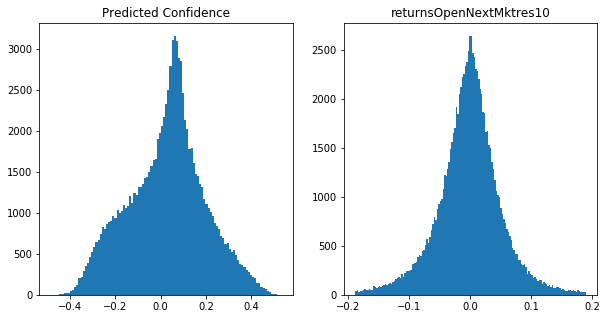

In [74]:
#model.load_weights('lstm_1.hdf5')
confidence_valid = np.array([lstm_1.predict(X.reshape(1,10,18))[0][0] for X in X_val]) * 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [75]:
#x_t_i = confidence_valid * r_val
x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.5051455943875386


# lstm_2

In [79]:
mkt_12 = market_train[market_train['time']>='2012-01-01']
mkt_12.head(3)
#import datetime
#mkt_12 = market_train[market_train['time']>=datetime.date(2012, 1, 1)]
print(mkt_12.shape)
sc_2 = StandardScaler(copy=False)
mkt_12.loc[:, num_cols] = sc_2.fit_transform(mkt_12.loc[:, num_cols])
mkt_12.head(3)

(1822736, 24)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,returnsOpenNextMktres10,universe,assetCode_cat_A,assetCode_cat_N,assetCode_cat_O,assetCode_cat_OB,assetCode_cat_OQ,assetCode_cat_P,assetCode_cat_UNKNOWN,label
1198758,2012-01-03,A.N,Agilent Technologies Inc,0.342215,-0.132770,-0.157030,2.674552,1.570394,1.094526,1.952257,...,0.085836,1.0,0,1,0,0,0,0,0,1
1198759,2012-01-03,AAN.N,Aaron's Inc,-0.589717,-0.512081,-0.488764,-0.145462,-0.028282,-1.359986,0.080472,...,-0.039223,0.0,0,1,0,0,0,0,0,0
1198760,2012-01-03,AAP.N,Advance Auto Parts Inc,-0.397878,1.123384,1.203039,-0.495313,0.953271,-1.430863,1.153025,...,0.072066,1.0,0,1,0,0,0,0,0,1


In [84]:
train_df, val_df = split(mkt_12)

cols = [col for col in market_train.columns if col not in ['time','assetCode', 'universe', 'label', 'assetName', 'returnsOpenNextMktres10']]
train_gen = SequenceGenerator(train_df, cols, batch_size=64)
test_gen = SequenceGenerator(val_df, cols, batch_size=64)
train_steps = train_gen.steps()
test_steps = test_gen.steps()

In [86]:
test = SequenceGenerator(val_df, cols, batch_size=100000, train=False)
X_val, y_val, r_val, u_val, d_val = next(test.generate())

In [87]:
lstm_2 = Sequential()
lstm_2.add(LSTM(30, input_shape=(10, len(cols)), return_sequences=False))
lstm_2.add(Dense(1, activation='sigmoid'))

lstm_2.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

check_point = ModelCheckpoint('lstm_2.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
lstm_2.fit_generator(train_gen.generate(),
          validation_data=test_gen.generate(),
          epochs=1,
          steps_per_epoch=train_steps, 
          validation_steps=test_steps,
          callbacks=[early_stop,check_point])

Epoch 1/1
21058/21058 [==============================] - 1681s 80ms/step - loss: 0.6814 - acc: 0.5627 - val_loss: 0.6868 - val_acc: 0.5402

Epoch 00001: val_loss improved from inf to 0.68679, saving model to lstm_2.hdf5


0.53784


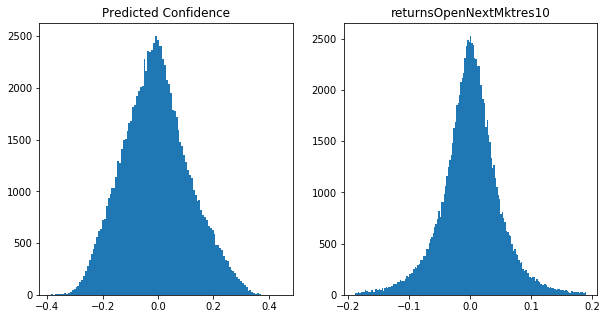

In [88]:
confidence_valid = np.array([lstm_2.predict(X.reshape(1,10,18))[0][0] for X in X_val]) * 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [89]:
x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.46637744634097655


# lstm_3

In [8]:
mkt_14 = market_train[market_train['time']>='2014-01-01']
print(mkt_14.shape)
sc_3 = StandardScaler(copy=False)
mkt_14.loc[:, num_cols] = sc_3.fit_transform(mkt_14.loc[:, num_cols])
mkt_14.head(3)

(1073528, 24)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,...,returnsOpenNextMktres10,universe,assetCode_cat_A,assetCode_cat_N,assetCode_cat_O,assetCode_cat_OB,assetCode_cat_OQ,assetCode_cat_P,assetCode_cat_UNKNOWN,label
2046131,2014-01-02,A.N,Agilent Technologies Inc,-0.039850,0.532691,0.566278,-1.041686,-0.382918,-0.551617,-0.516008,...,0.080747,1.0,0,1,0,0,0,0,0,1
2046132,2014-01-02,AAL.O,American Airlines Group Inc,2.321700,-0.613220,-0.623968,0.243117,0.789837,0.309625,0.917694,...,0.175047,1.0,0,0,1,0,0,0,0,1
2046133,2014-01-02,AAN.N,Aaron's Inc,-0.390292,-0.461299,-0.461949,0.084356,0.169917,0.186701,0.220264,...,-0.112403,1.0,0,1,0,0,0,0,0,0


In [91]:
train_df, val_df = split(mkt_14)

cols = [col for col in market_train.columns if col not in ['time','assetCode', 'universe', 'label', 'assetName', 'returnsOpenNextMktres10']]
train_gen = SequenceGenerator(train_df, cols, batch_size=64)
test_gen = SequenceGenerator(val_df, cols, batch_size=64)
train_steps = train_gen.steps()
test_steps = test_gen.steps()

In [217]:
cols = [col for col in market_train.columns if col not in ['time','assetCode', 'universe', 'label', 'assetName', 'returnsOpenNextMktres10']]

In [215]:
print(train_df.shape, val_df.shape)

(858822, 24) (213706, 24)


In [218]:
test = SequenceGenerator(val_df, cols, batch_size=100000, train=False)
X_val, y_val, r_val, u_val, d_val = next(test.generate())

In [94]:
lstm_3 = Sequential()
lstm_3.add(LSTM(30, input_shape=(10, len(cols)), return_sequences=False))
lstm_3.add(Dense(1, activation='sigmoid'))

lstm_3.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

check_point = ModelCheckpoint('lstm_3.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
lstm_3.fit_generator(train_gen.generate(),
          validation_data=test_gen.generate(),
          epochs=1,
          steps_per_epoch=train_steps, 
          validation_steps=test_steps,
          callbacks=[early_stop,check_point])

Epoch 1/1
11927/11927 [==============================] - 938s 79ms/step - loss: 0.6831 - acc: 0.5580 - val_loss: 0.6879 - val_acc: 0.5465

Epoch 00001: val_loss improved from inf to 0.68789, saving model to lstm_3.hdf5


0.54652


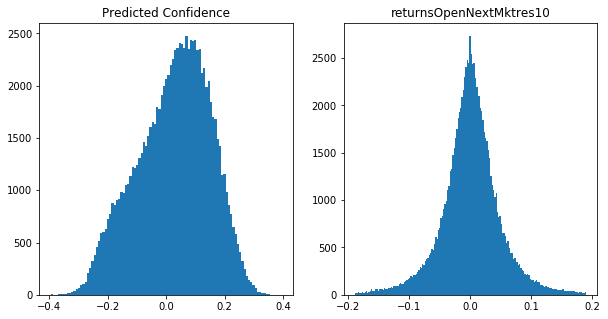

In [219]:
#model.load_weights('lstm_1.hdf5')
lstm_3.load_weights('lstm_3.hdf5')
confidence_valid = np.array([lstm_3.predict(X.reshape(1,10,18))[0][0] for X in X_val]) * 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [222]:
x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.5752902621438487


# prep news data

In [247]:
news_14 = pd.read_csv('news_since14_v1.csv')
news_14['assetCodes'] = news_14['assetCodes'].map(lambda x: x[2:-2].replace('\'', '').split(','))

#to_drop = ['sourceTimestamp', 'firstCreated', 'headline', 'provider', 'subjects', 'audiences','bodySize','headlineTag', 'sentenceCount','assetName','firstMentionSentence','sentimentClass']
#news_14.drop(to_drop, axis=1, inplace=True)

news_expand = []
for idx, row in news_14.iterrows():
    assetCodes_list = row['assetCodes']
    for i in range(len(assetCodes_list)):
        new_row = row
        new_row['assetCodes'] = assetCodes_list[i].strip()
        new_values = new_row.values
        news_expand.append(new_values)

news_num_cols = ['takeSequence','companyCount','wordCount','relevance', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D']
news_cat_cols = ['urgency', 'marketCommentary']



news_14.columns
['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline', 'urgency', 'takeSequence', 'provider', 'subjects', 'audiences', 'bodySize', 'companyCount', 'headlineTag', 'marketCommentary', 'sentenceCount', 'wordCount', 'assetCode', 'assetName', 'firstMentionSentence', 'relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D']

In [248]:
news_cols = list(news_14.columns)
for i in range(len(news_cols)):
    if news_cols[i] == 'assetCodes': 
        news_cols[i] = 'assetCode'
    
print(news_cols)

['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline', 'urgency', 'takeSequence', 'provider', 'subjects', 'audiences', 'bodySize', 'companyCount', 'headlineTag', 'marketCommentary', 'sentenceCount', 'wordCount', 'assetCode', 'assetName', 'firstMentionSentence', 'relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D']


In [249]:
news_expand = np.array(news_expand)
news_14_expand = pd.DataFrame(data=news_expand, index = range(len(news_expand)), columns=news_cols)
news_14_expand, news_cat_cols = one_hot_encoder(news_14_expand, news_cat_cols)
sc_4 = StandardScaler(copy=False)
news_14_expand.loc[:,news_num_cols] = sc_4.fit_transform(news_14_expand.loc[:,news_num_cols])


In [273]:
news_14_expand.shape

(4459356, 39)

In [272]:
news_14_expand['time'] = pd.to_datetime(news_14_expand['time'])
news_14_expand['sourceTimestamp'] = pd.to_datetime(news_14_expand['sourceTimestamp'])
news_14_expand['raw_time'] = news_14_expand['time']

In [281]:
from pandas.tseries.offsets import *
news_14_expand['time'] = news_14_expand['time'].map(lambda x: x+BDay())

In [282]:
news_14_expand['time'].head()

0   2014-01-02
1   2014-01-02
2   2014-01-02
3   2014-01-02
4   2014-01-02
Name: time, dtype: datetime64[ns]

In [289]:
mkt_14['time'] = pd.to_datetime(mkt_14['time'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [293]:
mn3y = mkt_14.merge(news_14_expand, on = ['time','assetCode'])


In [297]:
mn3y.to_csv('mn3y.csv', index=False)


news_14_expand['time'].dtype

ntest['time'] = ntest['time'].map(lambda x: x+BDay())
ntest['time']

ntest['time'] = pd.to_datetime(ntest['time'])

ntest['sourceTimestamp'] = pd.to_datetime(ntest['sourceTimestamp'])


ntest = news_14_expand[:10].copy()
ntest

mn_14 = mkt_14.merge(news_14_expand, on = ['time','assetCode'])
mn_14.to_csv('mn_14.csv', index=False)




In [245]:
news_14_expand.columns

Index(['time', 'sourceId', 'takeSequence', 'companyCount', 'wordCount',
       'assetCode', 'relevance', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H',
       'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D',
       'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D',
       'volumeCounts5D', 'volumeCounts7D', 'urgency_1', 'urgency_2',
       'urgency_3', 'marketCommentary_False', 'marketCommentary_True'],
      dtype='object')

news_14_expand.shape
(4459356, 26)

# lstm_4

In [199]:
train_df, val_df = split(mn_14)
print(train_df.shape, val_df.shape)

(1006663, 48) (250666, 48)


In [200]:
cols = [col for col in mn_14.columns if col not in ['time', 'assetCode', 'assetName', 'returnsOpenNextMktres10', 'universe', 'label', 'sourceId']]

train_gen = SequenceGenerator(train_df, cols, batch_size=64)
test_gen = SequenceGenerator(val_df, cols, batch_size=64)
train_steps = train_gen.steps()
test_steps = test_gen.steps()

In [201]:
test = SequenceGenerator(val_df, cols, batch_size=100000, train=False)
X_val, y_val, r_val, u_val, d_val = next(test.generate())

In [202]:
lstm_4 = Sequential()
lstm_4.add(LSTM(50, input_shape=(10, len(cols)), return_sequences=False))
lstm_4.add(Dense(1, activation='sigmoid'))

lstm_4.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])

check_point = ModelCheckpoint('lstm_4.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
lstm_4.fit_generator(train_gen.generate(),
          validation_data=test_gen.generate(),
          epochs=1,
          steps_per_epoch=train_steps, 
          validation_steps=test_steps,
          callbacks=[early_stop,check_point])

Epoch 1/1
14653/14653 [==============================] - 1441s 98ms/step - loss: 0.6904 - acc: 0.5424 - val_loss: 0.6938 - val_acc: 0.5202

Epoch 00001: val_loss improved from inf to 0.69376, saving model to lstm_4.hdf5


0.50653


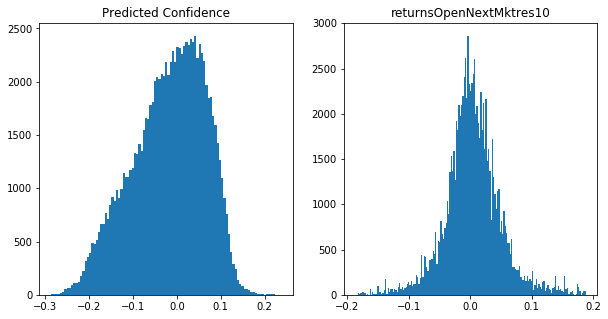

In [205]:
confidence_valid = np.array([lstm_4.predict(X.reshape(1,10,41))[0][0] for X in X_val]) * 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [208]:
x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

-0.11705816587099001


# lgb_3

In [298]:
mn3y, sentimentClass_cols = one_hot_encoder(mn3y, ['sentimentClass'])

In [301]:
train_df, val_df = split(mn3y)
print(train_df.shape, val_df.shape)

(1021182, 63) (254296, 63)


In [ ]:
no_use = ['time', 'assetCode', 'assetName_x', 'returnsOpenNextMktres10', 'universe', 'label', 'sourceId', 
         'sourceTimestamp', 'raw_time', 'firstCreated', 'headline', 'provider', 'subjects', 'audiences','bodySize','headlineTag', 'sentenceCount','assetName_y',
          'firstMentionSentence']
cols = [col for col in mn_14.columns if col not in no_use]


In [300]:
mn3y.shape

(1276478, 63)

In [302]:
param_3 = {'learning_rate': 0.005, 
           'n_estimators': 10000,
           'max_depth': 8, 
           'num_leaves': 255, 
           'boosting': 'gbdt', 
           'objective': 'binary', 
           'metric': 'auc', 
           'is_training_metric': True, 
           'seed': 66}
lgb_3 = lgb.train(param_3, num_boost_round=2000,
                  train_set = lgb.Dataset(train_df[cols], train_df['label']),
                  valid_sets = [lgb.Dataset(val_df[cols], val_df['label'])],
                  verbose_eval=50, early_stopping_rounds=50)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.520988
[100]	valid_0's auc: 0.522278
[150]	valid_0's auc: 0.523276
[200]	valid_0's auc: 0.524799
[250]	valid_0's auc: 0.525394
[300]	valid_0's auc: 0.524605
Early stopping, best iteration is:
[255]	valid_0's auc: 0.525439


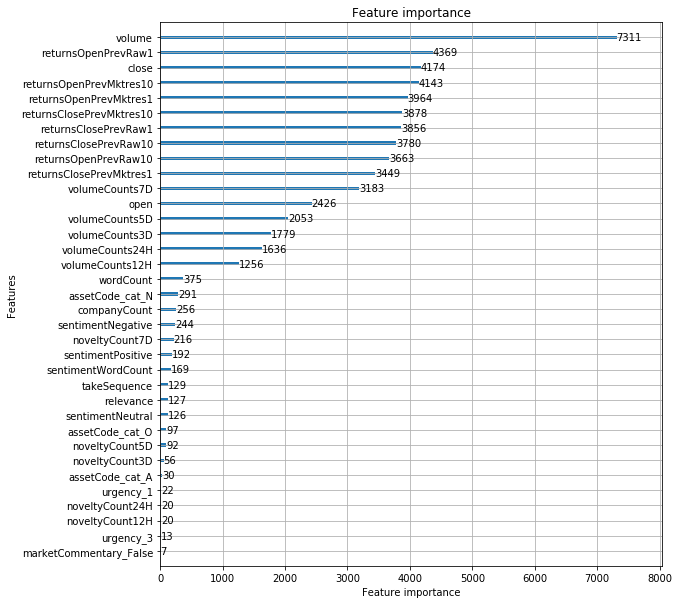

In [303]:
lgb.plot_importance(lgb_3, figsize=(9,10), height=0.2)

In [305]:
X_val = val_df[cols].iloc[1000:101000]
r_val = val_df.returnsOpenNextMktres10.iloc[1000:101000]
u_val = val_df.universe.iloc[1000:101000]
d_val = val_df.time.iloc[1000:101000]

confidence_valid = lgb_1.predict(X_val)* 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))

0.49161


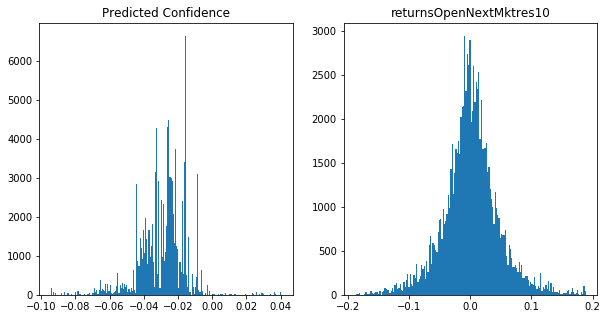

In [306]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
print(mean)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

# lgb_4 (mkt_14)

In [9]:
train_df, val_df = split(mkt_14)

cols = [col for col in market_train.columns if col not in ['time','assetCode', 'universe', 'label', 'assetName', 'returnsOpenNextMktres10']]


In [10]:
import lightgbm as lgb

param_1 = {'learning_rate': 0.005, 
           'n_estimators': 10000,
           'max_depth': 8, 
           'num_leaves': 255, 
           'boosting': 'gbdt', 
           'objective': 'binary', 
           'metric': 'auc', 
           'is_training_metric': True, 
           'seed': 66}

lgb_1 = lgb.train(param_1, num_boost_round=2000,
                  train_set = lgb.Dataset(train_df[cols], train_df['label']),
                  valid_sets = [lgb.Dataset(val_df[cols], val_df['label'])],
                  verbose_eval=50, early_stopping_rounds=50)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.539779
[100]	valid_0's auc: 0.540178
[150]	valid_0's auc: 0.540324
[200]	valid_0's auc: 0.540376
[250]	valid_0's auc: 0.540544
[300]	valid_0's auc: 0.540703
[350]	valid_0's auc: 0.540798
Early stopping, best iteration is:
[343]	valid_0's auc: 0.540808


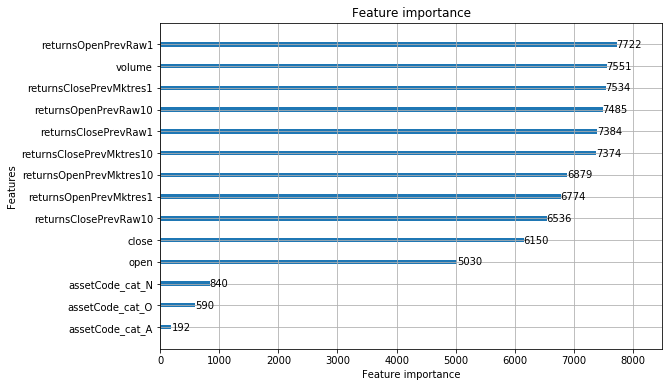

In [12]:
lgb.plot_importance(lgb_1, figsize=(9,6), height=0.2)

0.53867


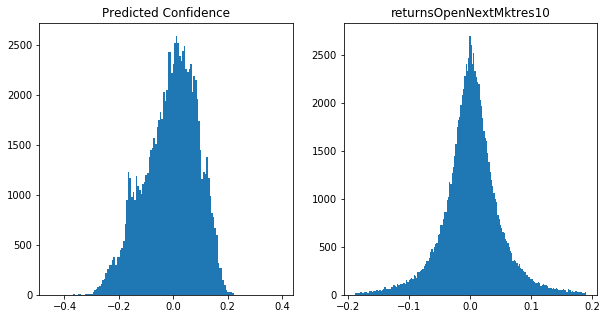

In [13]:
X_val = val_df[cols].iloc[1000:101000]
r_val = val_df.returnsOpenNextMktres10.iloc[1000:101000]
u_val = val_df.universe.iloc[1000:101000]
d_val = val_df.time.iloc[1000:101000]

confidence_valid = lgb_1.predict(X_val)* 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [16]:
x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
score_valid = mean / std
print(score_valid)

0.5678900106516751


# svm_1 (mn2y)

In [ ]:
from sklearn import svm
svm_1 = svm.SVC(kernel='poly', probability=True)
svm_1.fit(train_df[cols], train_df['label'])

In [ ]:
p = svm_1.predict_proba(val_df[cols])


In [ ]:
val_df['label']

# lgb_1 (mn_14)

In [223]:
train_df, val_df = split(mn_14)
print(train_df.shape, val_df.shape)

(1006663, 48) (250666, 48)


In [229]:
import lightgbm as lgb

param_1 = {'learning_rate': 0.005, 
           'n_estimators': 10000,
           'max_depth': 8, 
           'num_leaves': 255, 
           'boosting': 'gbdt', 
           'objective': 'binary', 
           'metric': 'auc', 
           'is_training_metric': True, 
           'seed': 66}


cols = [col for col in mn_14.columns if col not in ['time', 'assetCode', 'assetName', 'returnsOpenNextMktres10', 'universe', 'label', 'sourceId']]

lgb_1 = lgb.train(param_1, num_boost_round=2000,
                  train_set = lgb.Dataset(train_df[cols], train_df['label']),
                  valid_sets = [lgb.Dataset(val_df[cols], val_df['label'])],
                  verbose_eval=50, early_stopping_rounds=50)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.524389
Early stopping, best iteration is:
[14]	valid_0's auc: 0.527621


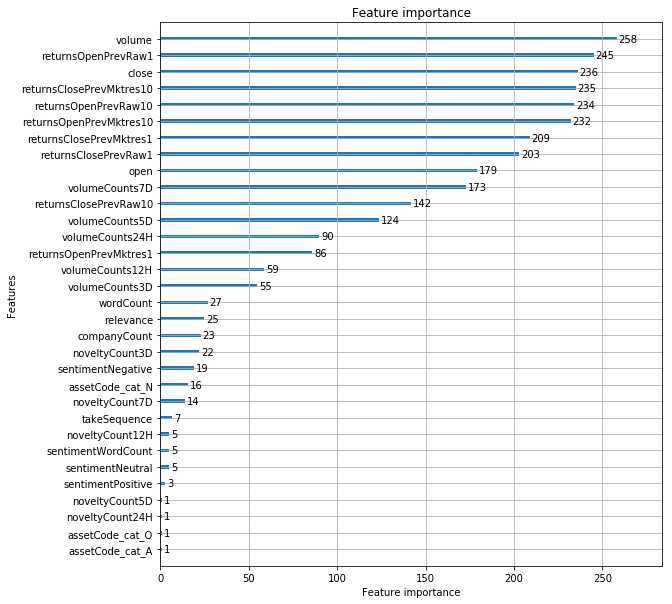

In [276]:
lgb.plot_importance(lgb_1, figsize=(9,10), height=0.2)

In [230]:
X_val = val_df[cols].iloc[1000:101000]
r_val = val_df.returnsOpenNextMktres10.iloc[1000:101000]
u_val = val_df.universe.iloc[1000:101000]
d_val = val_df.time.iloc[1000:101000]

In [235]:
confidence_valid = lgb_1.predict(X_val)* 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))

0.49154


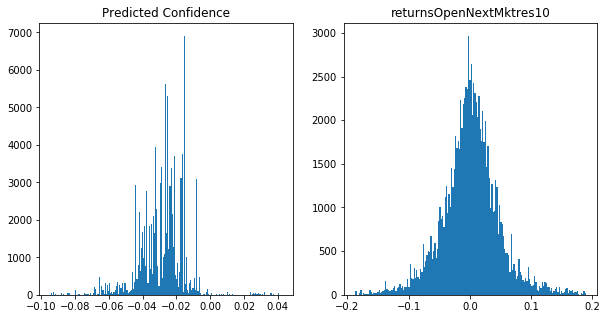

In [236]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

In [237]:
x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
print(mean)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

-0.10911341496253886


In [ ]:
X_val = val_df[cols].iloc[1000:101000]
r_val = val_df.returnsOpenNextMktres10.iloc[1000:101000]
u_val = val_df.universe.iloc[1000:101000]
d_val = val_df.time.iloc[1000:101000]

confidence_valid = lgb_1.predict(X_val) * 2 - 1

confidence_valid = np.array([lstm_4.predict(X.reshape(1,10,41))[0][0] for X in X_val]) * 2 - 1
print(accuracy_score(confidence_valid>0, r_val>0))
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(confidence_valid, bins='auto')
ax[0].set_title("Predicted Confidence")
ax[1].hist(r_val, bins='auto')
ax[1].set_title("returnsOpenNextMktres10")
plt.show()

x_t_i = confidence_valid * r_val
#x_t_i = confidence_valid * r_val * u_val
data = {'day' : d_val, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

In [238]:
mn_14.columns

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe', 'assetCode_cat_A',
       'assetCode_cat_N', 'assetCode_cat_O', 'assetCode_cat_OB',
       'assetCode_cat_OQ', 'assetCode_cat_P', 'assetCode_cat_UNKNOWN', 'label',
       'sourceId', 'takeSequence', 'companyCount', 'wordCount', 'relevance',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',
       'urgency_1', 'urgency_2', 'urgency_3', 'marketCommentary_False',
       'marketCommentary_True'],
      dtype=

# lgb_2 (mn_14)

In [239]:
ncols = [col for col in mn_14.columns if col not in ['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
                                                     'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
                                                     'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
                                                     'returnsOpenNextMktres10', 'assetCode_cat_A', 'assetCode_cat_N', 'assetCode_cat_O', 'assetCode_cat_OB',
                                                     'assetCode_cat_OQ', 'assetCode_cat_P', 'assetCode_cat_UNKNOWN','universe', 'label', 'sourceId']]

In [242]:
param_2 = {'learning_rate': 0.005, 
           'n_estimators': 10000,
           'max_depth': 5, 
           'boosting': 'gbdt', 
           'objective': 'binary', 
           'metric': 'auc', 
           'is_training_metric': True, 
           'seed': 66}

lgb_2 = lgb.train(param_2, num_boost_round=2000,
                  train_set = lgb.Dataset(train_df[ncols], train_df['label']),
                  valid_sets = [lgb.Dataset(val_df[ncols], val_df['label'])],
                  verbose_eval=50, early_stopping_rounds=50)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:102: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.488507
Early stopping, best iteration is:
[10]	valid_0's auc: 0.49107


In [169]:
news_14.shape

(2337588, 23)

In [30]:
# closing price by quatiles

data = []
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'))

In [31]:
layout = go.Layout(dict(title = "Closing prices by quantiles",
                        xaxis = dict(title = 'Month'),
                        yaxis = dict(title = 'Price (USD)')),
                   legend=dict(orientation="h"))

py.iplot(dict(data=data, layout=layout))

In [35]:
# returnsOpenNextMktres10 by quantiles
data = []
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'))

layout = go.Layout(dict(title = "returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)')),
                   legend=dict(orientation="h"))
py.iplot(dict(data=data, layout=layout))

In [50]:
len(val_df)

421562